In [1]:
## using Pkg
## Pkg.add("PlotlyJS")

In [2]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Distributed
using Plots

In [3]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM.jl/analysis"

In [4]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

In [5]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [6]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

heritabilities = Array{Float64, 1}(undef, m);


for j in 1:m
    heritabilities[j] = scan(reshape(pheno[:, j], :, 1), geno, kinship; reml = true)[2] 
end

histogram(heritabilities[1:7000], bins = 100)

length(heritabilities)

plot(heritabilities)

findmax(heritabilities)

In [7]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [8]:
include("../src/scan.jl");

In [9]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 100);

  876.718 ms (183990 allocations: 1.37 GiB)


In [10]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 1024); # output structures of function

  7.764 s (194772 allocations: 13.63 GiB)


In [11]:
results_nperms = scan_perms(pheno_y, geno, kinship); # output structures of function

In [12]:
size(results_nperms)

(1025, 7321)

## Do the same for many traits (first 1000):

In [13]:
# Function that extracts the row maximums for a matrix:
function getMaxLod_manyTraits(pheno::Array{Float64, 2}, geno::Array{Float64, 2}, kinship::Array{Float64, 2};
                              ntraits::Int64 = 1000, nperms::Int64 = 1024, original::Bool = true)
    
    if original
        nrows = nperms+1
    else
        nrows = nperms
    end
    
    maxLods_manyTraits = Matrix{Float64}(undef, nrows, ntraits);
    
    for k in 1:ntraits
        
        pheno_k = reshape(pheno[:, k], :, 1);
        results = scan_perms(pheno_k, geno, kinship; nperms = nperms)
        
        maxLods_manyTraits[:, k] = getMaxLod(results)
    end
    
    return maxLods_manyTraits; 
end


function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end

getMaxLod (generic function with 1 method)

In [14]:
maxLods = getMaxLod(results_nperms);

In [15]:
typeof(maxLods)

Matrix{Float64} (alias for Array{Float64, 2})

In [16]:
size(maxLods)

(1025, 1)

In [17]:
quantile(maxLods[:, 1], 0.95)

3.74391432344263

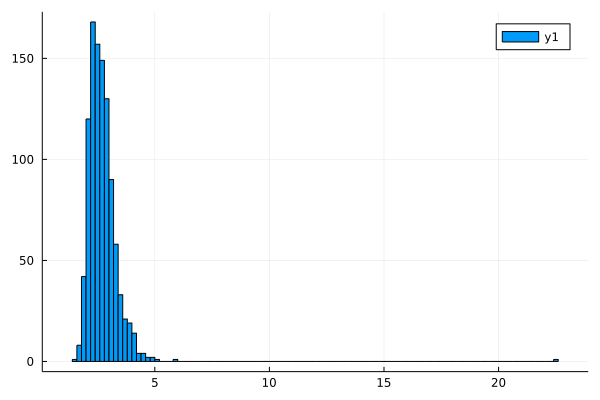

In [18]:
histogram(maxLods)

In [19]:
typeof(pheno_y)

Matrix{Float64} (alias for Array{Float64, 2})

In [20]:
@btime scan(pheno_y, geno, kinship);

  19.095 ms (101879 allocations: 34.44 MiB)


In [21]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 0); # using rowDivide! with 1./sqrt(wts)

  27.545 ms (161026 allocations: 49.72 MiB)


In [22]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 0); # using rowMultiply! with sqrt(wts)

  27.963 ms (161026 allocations: 49.72 MiB)


In [23]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1, nperms = 1024);

  7.498 s (205853 allocations: 13.63 GiB)


In [24]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 1);

  3.910 s (16235283 allocations: 6.20 GiB)


In [25]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 1);

  38.912 s (162252814 allocations: 61.91 GiB)


In [26]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 10);

  12.048 s (16251483 allocations: 18.27 GiB)


In [27]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 10);

  118.656 s (162414815 allocations: 182.64 GiB)


In [28]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 20);

  14.950 s (16269484 allocations: 31.56 GiB)


In [29]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 20);

  161.510 s (162594815 allocations: 315.54 GiB)


In [31]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 100, nperms = 100);

  113.844 s (18609884 allocations: 137.52 GiB)


In [30]:
b = @benchmark getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 100);

In [32]:
maxLods_1000Traits = getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 100);

In [33]:
size(maxLods_1000Traits)

(101, 1000)

In [34]:
maxLods_1000Traits;

In [35]:
quantile_1000Traits = mapslices(x -> quantile(x, 0.95), maxLods_1000Traits; dims = 1);

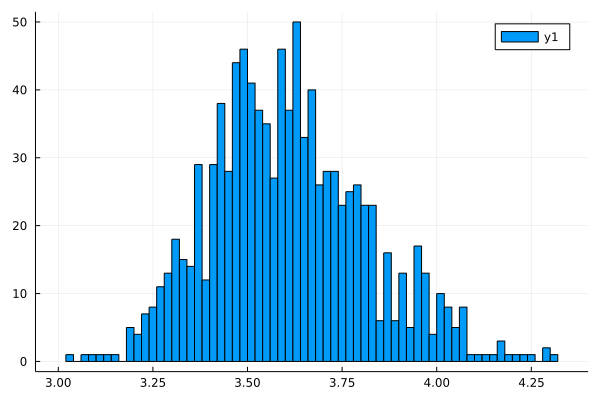

In [36]:
histogram(vec(quantile_1000Traits), bins = 100)

In [37]:
findmax(quantile_1000Traits)

(4.312500541959158, CartesianIndex(1, 232))

In [40]:
b

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 1142.314 s (20.16% GC) to evaluate,
 with a memory estimate of 1375.11 GiB, over 185998815 allocations.

In [92]:
ntraits_list = [1, 10, 100, 1000];
nperms_list = [0, 10, 100, 1000];

In [85]:
runtimes_list = Array{Float64, 2}(undef, length(ntraits_list), length(nperms_list));
memorys_list = Array{Float64, 2}(undef, length(ntraits_list), length(nperms_list));

In [ ]:
for i in 1:length(ntraits_list)
    
    ntraits = ntraits_list[i];
    
    for j in 1:length(nperms_list)
        
        nperms = nperms_list[i];
        
        b = @benchmark getMaxLod_manyTraits(pheno, geno, kinship; ntraits = $ntraits, nperms = $nperms);
        b = median(b);
        runtimes_list[i, j] = time(b)/1e9;
        memorys_list[i, j] = memory(b)/(1024*1024*1024);
    
    end
end

In [105]:
runtimes_list

4×4 Matrix{Float64}:
    0.0329701  1142.31  1142.31  1142.31
 1142.31       1142.31  1142.31  1142.31
 1142.31       1142.31  1142.31  1142.31
 1142.31       1142.31  1142.31  1142.31

In [ ]:
memorys_list

In [73]:
mean(b)

BenchmarkTools.TrialEstimate: 
  time:             1142.314 s
  gctime:           230.276 s (20.16%)
  memory:           1375.11 GiB
  allocs:           185998815

In [77]:
1476518178592/(1024*1024*1024)

1375.1147115528584

In [81]:
time(b)/1e9

1142.314095826

In [80]:
memory(b)

1476518178592